Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 29-July-2025

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from caveclient import CAVEclient

In [47]:
def convert_to_nm(col, voxel_size=[4.3,4.3,45]):
    return np.vstack(col.values)*voxel_size

In [48]:
# Select cell type
#cell_type = ['claw_flx','claw_ext']
cell_type = ['hook_flx','hook_ext']

# Select whether to plot input synapses (or output synapses)
query_input_syn = True

In [49]:
# Initialize CAVEclient
# This step requires an authentication token, see https://caveclient.readthedocs.io/en/latest/guide/authentication.html
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.version = 840

In [50]:
# Get IDs of FeCO neurons from annotation table  
df = client.materialize.query_table('feco_axons_v0', filter_in_dict = {'cell_type': cell_type})

# Exclude partially reconstructed claw axons
pt_position_to_exclude = np.array([[9093, 101264, 3740], [9401, 100947, 3740]])
index_to_exclude = []
for index, _ in df.iterrows():
    if (df.pt_position[index] == pt_position_to_exclude).all(axis=1).any():
        index_to_exclude.append(index)
df = df.drop(index_to_exclude)

# Get IDs 
ids = df.pt_root_id.tolist()

In [51]:
len(ids)

22

In [52]:
# Query input or output synapses 
if query_input_syn == True:
    df_syn = client.materialize.synapse_query(post_ids = ids)
else:
    df_syn = client.materialize.synapse_query(pre_ids = ids)

In [53]:
# Remove connections less than syn_thresh  
syn_thresh = 0;
df_syn_summed = df_syn
df_syn_summed['syn_count'] = 1
df_syn_summed = df_syn_summed.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_syn_summed = df_syn_summed[df_syn_summed.syn_count >= syn_thresh]

keys = ['pre_pt_root_id','post_pt_root_id']
i1 = df_syn.set_index(keys).index
i2 = df_syn_summed.set_index(keys).index
df_syn = df_syn[i1.isin(i2)]

In [54]:
# Convert synapse positions to nm
input_syn_pos = convert_to_nm(df_syn.post_pt_position)
output_syn_pos = convert_to_nm(df_syn.pre_pt_position)

# Note that y points posteriorly in Neuroglancer, so flip sign 
input_syn_pos[:,1] = -input_syn_pos[:,1]
output_syn_pos[:,1] = -output_syn_pos[:,1]

In [55]:
# Select whether to plot presynaptic sites (output synapses) or postsynaptic sites (input synapses)
if query_input_syn == True:
    x = input_syn_pos[:,0]
    y = input_syn_pos[:,1]
    print('Number of synapses: ' + str(len(input_syn_pos)))
else:
    x = output_syn_pos[:,0]
    y = output_syn_pos[:,1]
    print('Number of synapses: ' + str(len(output_syn_pos)))

Number of synapses: 1388


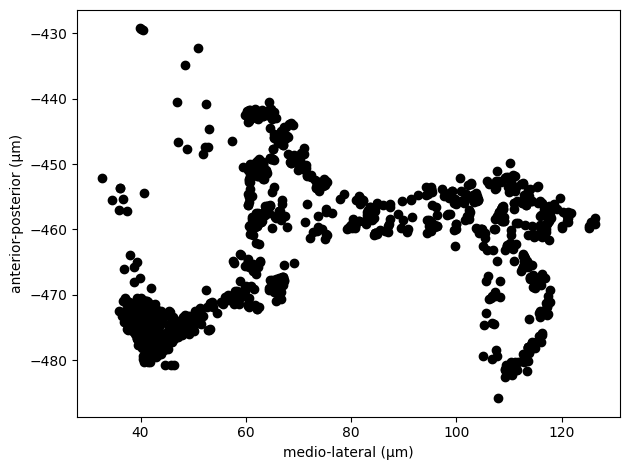

In [56]:
# Plot synapse positions in x-y plane in micrometers
fig, ax = plt.subplots()
ax.scatter(x/1000, y/1000, color='k', alpha=1)
plt.xlabel('medio-lateral (µm)')
plt.ylabel('anterior-posterior (µm)')
plt.tight_layout()
plt.show()